In [1]:
from typing import List
from matplotlib import pyplot as plt
import numpy as np

from importlib import reload
import pisces.models as pm

from pisces.utils import pad_to_hat, plot_scores_CDF, plot_scores_PDF, add_rocs
import matplotlib.pyplot as plt

from pisces.data_sets import DataSetObject


sets = DataSetObject.find_data_sets("../data_sets")
walch = sets['walch_et_al']
hybrid = sets['hybrid_motion']

In [2]:

mo = pm.MOResUNetPretrained(sampling_hz=32)


In [20]:
from sklearn.metrics import auc as area
def roc_for_class(X, y, neg_class: int):
    pr = mo.predict_probabilities(X)[0]
    p_not_class = 1 - pr[:, neg_class]
    y_padded = np.zeros_like(p_not_class)
    mask = np.zeros_like(p_not_class)
    # just score the class
    y_padded[:y.shape[0]] = y != neg_class
    # PSG with negative value indicates to ignore that epoch
    mask[:y.shape[0]] = y >= 0
    
    return pm.roc_curve(y_padded, p_not_class, sample_weight=mask)

# Walch et al. data set

## (MO) Pretrained UNet evaluation
We have the trained weights from Mads Olsen et al.'s _ResUNet_ model, saved as a tensorflow lite model with a wrapper for our system. This section calls that on accelerometer recordings in the `'walch_et_al'` data set.

In [4]:
# uses all processors on your CPU to preprocess the accelerometer into spectrograms
# takes ~ 50 sec on M1 Pro (10core)
evaluations_walch, mo_preprocessed_data_walch = mo.evaluate_data_set(walch)
mo_aucs_walch = [e["auc"] for e in evaluations_walch.values()]
mo_fprs_walch = [e["roc_curve"]["fprs"] for e in evaluations_walch.values()]
mo_tprs_walch = [e["roc_curve"]["tprs"] for e in evaluations_walch.values()]


Using 16 of 16 cores (100%) for parallel preprocessing.
This can cause memory or heat issues if  is too high; if you run into problems, call prepare_set_for_training() again with max_workers = -1, going more negative if needed. (See the docstring for more info.)


getting needed X, y for 3997827
getting needed X, y for 46343
getting needed X, y for 1066528
getting needed X, y for 2598705
getting needed X, y for 1360686
getting needed X, y for 4426783
getting needed X, y for 5132496
getting needed X, y for 4018081
getting needed X, y for 5498603
getting needed X, y for 3509524
getting needed X, y for 2638030
getting needed X, y for 5383425
getting needed X, y for 1818471
getting needed X, y for 1449548
getting needed X, y for 4314139
getting needed X, y for 1455390
sampling hz: 32
masking
Masked 1 PSG epochs
resampling to 32Hz (0.03125s) from 50 Hz (0.01997s)
sampling hz: 32
masking
Masked 1 PSG epochs
resampling to 32Hz (0.03125s) from 10 Hz (0.09990s)
sampling hz: 32
masking
Masked 1 PSG epochs
sampling hz: 32
masking
sampling hz: 32
masking
resampling to 32Hz (0.03125s) from 66 Hz (0.01505s)
sampling hz: 32
masking
sampling hz: 32
masking
sampling hz: 32
masking
Masked 1 PSG epochs
sampling hz: 32
masking
sampling hz: 32
masking
resampling to 

In [17]:
X_0, y_0 = mo_preprocessed_data_walch[0][0]

fpr_pre, tpr_pre, thr_pre = roc_for_class(X_0, y_0, 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


In [21]:
area(fpr_pre, tpr_pre)

0.5772981870889266

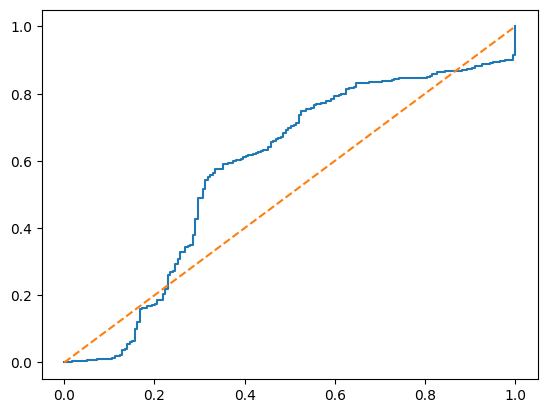

In [22]:
plt.plot(fpr_pre, tpr_pre)
plt.plot([0, 1], [0, 1], linestyle="--")

In [23]:
x = np.array([[1.0, 2, 3]])
print(x)

[[1. 2. 3.]]


In [24]:
np.pad(
    x,
    pad_width=[
        (2, 1),
        (0, 3),
    ]
)

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 2., 3., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [25]:
def pad_to_length(y: np.ndarray, length: int):
    return np.pad(
        y,
        pad_width=[
            (0, 0),
            (0, length - y.shape[0]),
        ]
    )

In [29]:
reload(pm)


walch_mo_run = pm.run_split(
    train_indices=list(range(1, 29)),
    preprocessed_data_set=mo_preprocessed_data_walch,
    swc=mo,
    epochs=3
)

Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 1.8532 - val_loss: 0.9759
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 1.4442 - val_loss: 0.9580
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 1.2677 - val_loss: 0.9464


In [30]:
fprs, tprs, theta = roc_for_class(X_0, y_0, 0)
print("AUROC:", area(fprs, tprs))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
AUROC: 0.6548112431078059


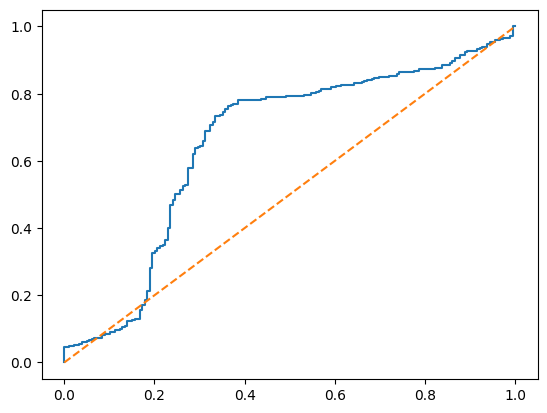

In [31]:
plt.plot(fprs, tprs)
plt.plot([0, 1], [0, 1], linestyle="--")